## Clone Repository

In [21]:
!rm *.py
!git clone https://github.com/tanmaybinaykiya/CS-7643-Deep-Learning-Final-Project.git 
!mv CS-7643-Deep-Learning-Final-Project/*.py .
!rm -rf 'CS-7643-Deep-Learning-Final-Project'
!mkdir data
!mkdir dataset

Cloning into 'CS-7643-Deep-Learning-Final-Project'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 173 (delta 78), reused 135 (delta 42), pack-reused 0
Receiving objects: 100% (173/173), 31.51 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (78/78), done.
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘dataset’: File exists


## Download datasets

### Download GloVe

In [2]:
!wget 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
!unzip 'glove.840B.300d.zip'
!rm glove.840B.300d.zip
!mv glove.840B.300d.txt data/

--2018-11-26 01:47:58--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2018-11-26 01:47:58--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  37.2MB/s    in 46s     

2018-11-26 01:48:44 (45.2 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


### Download Squad

In [3]:
!mkdir dataset
!curl -o 'dataset/squad-train-v1.1.json' 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json' 
!curl -o 'dataset/squad-dev-v1.1.json' 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json' 

mkdir: cannot create directory ‘dataset’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.8M  100 28.8M    0     0  24.4M      0  0:00:01  0:00:01 --:--:-- 24.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4740k  100 4740k    0     0  4090k      0  0:00:01  0:00:01 --:--:-- 4090k


### Data Preprocessor

Builds question answer pairs

In [7]:
%load_ext autoreload
%autoreload 2
from DataProcessor import main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
main()

data/answer_glove_embeddings.npy doesn't exist. Pruning...
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'mylot.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
Error occured but ignored  could not convert string to float: 'Amazon.com'
Error occured but ignored  could not convert string to float: 'name@domain.com'
data/question_glove_embeddings.npy doesn't exist. Pruning...
Error occur

# Install Libraries

## Install Pytorch

In [9]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print("platform, accelerator:", platform, accelerator)
!pip install -v -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

platform, accelerator: cp36-cp36m cu80
    100% |████████████████████████████████| 484.0MB 50.3MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b25a000 @  0x7fd56a1ca2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 1.1MB/s 
    100% |████████████████████████████████| 2.0MB 2.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


# Train Model

### Imports

In [0]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader

from constants import DatasetPaths

from DataLoader import SquadDataset, collate_fn, GloVeEmbeddings
from models import EncoderBILSTM, DecoderLSTM
from train import train

### Run Model

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

def plot_losses(losses):
  plt.plot(losses)

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch')
  plt.grid(True)

  plt.show()

In [0]:
print(DatasetPaths)
use_cuda=True
use_cuda = use_cuda and torch.cuda.is_available()

train_dataset = SquadDataset(split="train")
word_to_idx_sent = train_dataset.get_answer_word_to_idx()
word_to_idx_q = train_dataset.get_question_idx_to_word()

train_vocab_size_sent = len(word_to_idx_sent)
train_vocab_size_q = len(word_to_idx_q)
num_epoch = 15
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn,
                          pin_memory=True)

train_iter = iter(train_loader)

word_embeddings_glove_q = GloVeEmbeddings.load_glove_embeddings(True)
word_embeddings_glove_sent = GloVeEmbeddings.load_glove_embeddings(False)

encoder = EncoderBILSTM(vocab_size=train_vocab_size_sent, n_layers=2, embedding_dim=300, hidden_dim=500,
                        dropout=0, embeddings=word_embeddings_glove_sent)
decoder = DecoderLSTM(vocab_size=train_vocab_size_q, embedding_dim=300, hidden_dim=500, n_layers=1,
                      encoder_hidden_dim=500, embeddings=word_embeddings_glove_q)

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

n_train = len(train_loader)
batch_per_epoch = n_train // batch_size

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer_enc = torch.optim.SGD(encoder.parameters(), lr=1.0)
optimizer_dec = torch.optim.SGD(decoder.parameters(), lr=1.0)

if not os.path.isdir("model_weights"):
    os.makedirs("model_weights", exist_ok=True)

losses= train(encoder, decoder, num_epoch, batch_per_epoch, train_iter, criterion, optimizer_enc, optimizer_dec, use_cuda)

dev_dataset = SquadDataset(split="dev")

dev_loader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, pin_memory=True)

{'paragraphs-path': './data/%s/paragraphs.json', 'question-answer-pairs-path': './data/%s/q_a_pairs.json', 'glove': {'original-embeddings': 'data/glove.840B.300d.txt', 'answer-embeddings': 'data/answer_glove_embeddings.npy', 'question-embeddings': 'data/question_glove_embeddings.npy'}, 'squad': {'dev': 'dataset/squad-dev-v1.1.json', 'train': 'dataset/squad-train-v1.1.json'}, 'word-to-idx-path': {'question': './data/%s/q_word_to_idx.json', 'answer': './data/%s/a_word_to_idx.json'}, 'idx-to-word-path': {'question': './data/%s/q_idx_to_word.json', 'answer': './data/%s/a_idx_to_word.json'}}
Loss for the batch is
9.599814278738839
Loss for the batch is
7.310170968373616
Loss for the batch is
6.287847950344994
Loss for the batch is
5.86910141082037
Loss for the batch is
5.396195320856004
Loss for the batch is
5.087418011256626
Loss for the batch is
4.895715213957287
Loss for the batch is
4.696955680847168
Loss for the batch is
4.543903123764765
Loss for the batch is
4.363599845341274


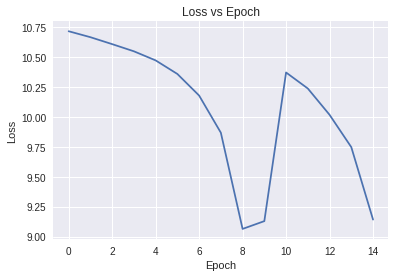

In [20]:
plot_losses(losses)